In [1]:
#%xmode Verbose

In [2]:
import sys
sys.path.append("../libs/")
sys.path.append("../../../deep-belief-network/")

In [3]:
from dbn.models import SupervisedDBNRegression

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import shift_join_data, mae,rmse,mape, plot_pred, plot_history, split_df, flatten
from keras.models import load_model

# Carga de datos

In [5]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

In [6]:
#df_train, df_test = split_df(df, 0.3)
#df_val = df_test.copy()

In [7]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444 entries, ('DEU', 1983) to ('NZL', 2021)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2444 non-null   float64
 1   exports      2444 non-null   float64
 2   imports      2444 non-null   float64
 3   ggfce        2444 non-null   float64
 4   gfcf         2444 non-null   float64
 5   unempl       2444 non-null   float64
 6   rgdp_growth  2444 non-null   float64
 7   infl_cpi     2444 non-null   float64
 8   oil          2444 non-null   float64
 9   gold         2444 non-null   float64
 10  copper       2444 non-null   float64
 11  sp500        2444 non-null   float64
dtypes: float64(12)
memory usage: 239.0+ KB


# Dividir Datos

In [9]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]

In [10]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [11]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'unempl', 'infl_cpi',
       'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


In [12]:
_, df_test = split_df(df,1)

g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_temp.loc[ : test_year].copy())
g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_temp.loc[test_year : ].copy())
g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_temp.loc[ : test_year].copy())
g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

# Normalizar

In [13]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

# minmax_scaler_x_train = MinMaxScaler()
# minmax_scaler_y_train = MinMaxScaler()
# minmax_scaler_x_test = MinMaxScaler()
# minmax_scaler_y_test = MinMaxScaler()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

# df_x_train.iloc[:,:] = minmax_scaler_x_train.fit_transform(df_x_train)
# df_y_train.iloc[:,:] = minmax_scaler_y_train.fit_transform(df_y_train)
# df_x_test.iloc[:,:] = minmax_scaler_x_test.fit_transform(df_x_test)
# df_y_test.iloc[:,:] = minmax_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_y_train.iloc[:,:] = np.clip(df_y_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)
df_y_test.iloc[:,:] = np.clip(df_y_test,-5,5)

# Generar variables lag y horizonte

In [14]:
n_steps_in = 10
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)

In [17]:
n_batch = len(x_train)

In [18]:
n_batch

1695

In [19]:
#mlp = build_mlp(n_steps_in,n_features,n_steps_out,304,4,1e-4,'relu')
#model = load_model('ajustes/Seq2Seq_20220724_2143.h5')

In [96]:
nodes = 200
rbm_layers = 3
h_layers_structure = [nodes for i in range(rbm_layers)]
learning_rate_rbm=1e-4
learning_rate=1e-2
n_epochs = 20
n_iter_backprop=200
batch_size=32
activation_function='relu'
dropout_p = 0.1

In [109]:
model = SupervisedDBNRegression(
    hidden_layers_structure = h_layers_structure,
    learning_rate_rbm = learning_rate_rbm,
    learning_rate = learning_rate,
    n_epochs_rbm = n_epochs,
    n_iter_backprop = n_iter_backprop,
    batch_size = batch_size,
    activation_function = activation_function,
    dropout_p = dropout_p,
    verbose = False
)

In [98]:
x_train = flatten(x_train)
x_test = flatten(x_test)
#y_train = y_train.flatten()
#y_test = y_test.flatten()

In [110]:
model.fit(x_train, y_train)

SupervisedDBNRegression()

In [24]:
#history = model.fit(x_train,y_train,epochs=2000,batch_size=32,validation_split=0.3,verbose=0,callbacks=[es],shuffle=False)

In [111]:
#plot_history(history,'loss')

In [112]:
y_pred = model.predict(x_test)

In [27]:
#shape = y_pred.shape
#y_pred = y_pred.reshape(shape[0],shape[1])

In [113]:
# dn_y_test = minmax_scaler_y_test.inverse_transform(y_test)
# dn_y_pred = minmax_scaler_y_test.inverse_transform(y_pred)

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

In [114]:
print(mae(dn_y_test, dn_y_pred))
print(rmse(dn_y_test, dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

[4.03451741 3.69207616 4.16236771]
[6.20927902 5.60140544 6.09772564]
[256.02069602 227.51232458 225.37167692]


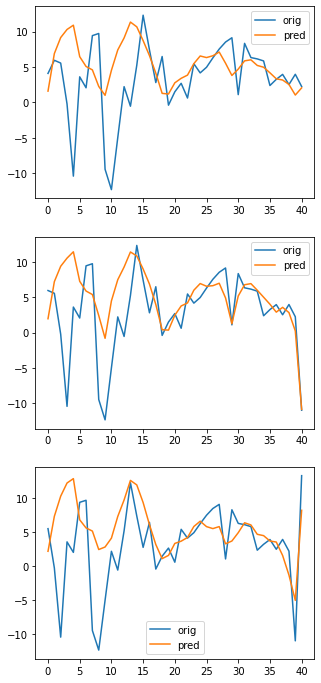

In [115]:
plot_pred(dn_y_test,dn_y_pred)